In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from fiona.crs import from_epsg
import pulp
from sklearn import linear_model
import statsmodels.api as sm
import shapely
import re
from itertools import product

%matplotlib inline

# Data

In [3]:
man = pd.read_csv('manhattan_grids_final.csv', index_col=0)
man.rename(columns={'0': 'GRID_ID'}, inplace=True)

In [4]:
matrix = np.load('neighbour.npy')

In [5]:
df = gpd.GeoDataFrame.from_file('Manhattan/manhattan.shp')

In [6]:
hex_usage = pd.read_csv('hex_usage.csv', index_col=0)

In [7]:
df_man = gpd.GeoDataFrame(pd.merge(man, df, on='GRID_ID', how='left'))

df_man = df_man.merge(hex_usage, on='GRID_ID', how='left')
df_man.fillna(0, inplace=True)

In [8]:
df_man.car_usage.sum() / df_man.idle_count.sum()

0.04767913045565828

# Regression

In [9]:
hu = hex_usage.merge(df, on='GRID_ID', how='left')

In [10]:
hu.columns

Index(['GRID_ID', 'time_usage', 'car_usage', 'Bangladesh', 'dropoff_co',
       'geometry', 'hotel', 'idle_count', 'idle_time_', 'parks', 'pickup_cou',
       'rest_cheap', 'rest_india', 'rs_count', 'violations'],
      dtype='object')

In [11]:
hu['ratio'] = hu.apply(lambda row: row['car_usage']/row["idle_count"], axis=1)
y_train = hu['ratio']
x_train = hu.loc[:,['dropoff_co', 'pickup_cou', 'hotel', 'parks', 'rest_cheap']]

In [12]:
for c in x_train.columns:
    lr = sm.OLS(y_train, sm.add_constant(x_train[c])).fit()
    print(c)
    print(lr.summary())
    print('\n')

dropoff_co
                            OLS Regression Results                            
Dep. Variable:                  ratio   R-squared:                       0.216
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     8.276
Date:                Sun, 30 Jul 2017   Prob (F-statistic):            0.00733
Time:                        14:23:30   Log-Likelihood:                 7.5574
No. Observations:                  32   AIC:                            -11.11
Df Residuals:                      30   BIC:                            -8.183
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4213      0.078      5.3

In [33]:
lr = sm.OLS(y_train, x_train.drop('parks', axis=1)).fit()
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     8.568
Date:                Sun, 30 Jul 2017   Prob (F-statistic):           0.000120
Time:                        20:31:33   Log-Likelihood:                 5.0544
No. Observations:                  32   AIC:                            -2.109
Df Residuals:                      28   BIC:                             3.754
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
dropoff_co  4.695e-06      0.000      0.029      0.977      -0.000       0.000
pickup_cou -7.727e-05      0.000     -0.585      0.563      -0.000       0.000
hotel          0.0016      0.003      0.550      0.587      -0.004       0.008
rest_cheap     0.0071      0.002      3.154      0.004       0.003       0.012
==============================================================================
Omnibus:                       21.445   Durbin-Watson:                   2.338
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.316
Skew:                           1.709   Prob(JB):                     1.58e-07
Kurtosis:                       6.437   Cond. No.                         343.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
p = lr.predict(df_man.loc[:,['dropoff_co', 'pickup_cou', 'hotel', 'rest_cheap']])

inl = hu.GRID_ID.apply(lambda n: np.where(df_man.GRID_ID == n)[0][0])

p[inl] = hu['ratio']

p[np.where(p < 0)[0]] = 0

p.mean()

0.1420665323177491

In [13]:
lr = sm.OLS(y_train, sm.add_constant(x_train.drop('parks', axis=1))).fit()

In [14]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  ratio   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     2.198
Date:                Sun, 30 Jul 2017   Prob (F-statistic):             0.0960
Time:                        14:23:37   Log-Likelihood:                 8.1699
No. Observations:                  32   AIC:                            -6.340
Df Residuals:                      27   BIC:                            0.9889
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6246      0.259      2.409      0.023       0.093       1.156
dropoff_co -5.376e-05      0.000     -0.356      0.725      -0.000       0.000
pickup_cou -2.589e-05      0.000     -0.209      0.836      -0.000       0.000
hotel          0.0013      0.003      0.489      0.629      -0.004       0.007
rest_cheap    -0.0052      0.006     -0.940      0.355      -0.017       0.006
==============================================================================
Omnibus:                       29.038   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.854
Skew:                           2.026   Prob(JB):                     8.26e-15
Kurtosis:                       8.677   Cond. No.                     2.90e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.9e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [ ]:
plt.scatter(lr.predict(sm.add_constant(x_train.drop('parks', axis=1))), y_train)

In [16]:
p = lr.predict(sm.add_constant(df_man.loc[:,['dropoff_co', 'pickup_cou', 'hotel', 'rest_cheap']]))

inl = hu.GRID_ID.apply(lambda n: np.where(df_man.GRID_ID == n)[0][0])

p[inl] = hu['ratio']

p[np.where(p < 0)[0]] = 0

In [17]:
p.mean()

0.4356955159555918

# LP

In [36]:
size = 423
R = 20
w0 = 0.8
w1 = 0.2
alpha = 10.

In [37]:
trs_model = pulp.LpProblem("trs Problem", pulp.LpMaximize)

### Independant Variables

x = pulp.LpVariable.dict('x_%s', range(size))
y = pulp.LpVariable.dict('y_%s', range(size), lowBound=0, upBound=1, cat="Binary")

### Object Function

c = df_man.apply(lambda row: (row['violations']+1)/(row["idle_count"]+1), axis=1)
trs_model += sum([c[i] * p[i] * x[i] for i in range(size)])

### Constraints

trs_model += sum([y[i] for i in range(size)]) <= R

for i in range(size):
    trs_model += x[i] <= df_man.loc[i, "idle_count"]/alpha
    trs_model += x[i] <= w0*y[i] + w1*sum([y[j] for j in np.where(matrix[i, :] == 1)[0]])

In [38]:
trs_model.solve()

1

In [39]:
ids = []
for v in trs_model.variables():
    if v.name.startswith("y") & (v.varValue == 1):
        ids.append(df_man.loc[int(v.name[2:]),'GRID_ID'])

In [40]:
ids

['BG-33',
 'BK-37',
 'BL-32',
 'BG-43',
 'BN-38',
 'AZ-54',
 'BM-33',
 'BI-38',
 'BH-41',
 'BG-40',
 'BL-34',
 'BH-39',
 'BG-41',
 'BN-34',
 'BC-37',
 'BG-36',
 'BH-44',
 'BF-37',
 'BE-45',
 'BB-51']

In [289]:
ids

['BI-30',
 'BG-33',
 'BO-34',
 'BK-37',
 'BL-32',
 'BG-43',
 'BF-34',
 'BN-38',
 'AZ-54',
 'BM-33',
 'BH-41',
 'BG-40',
 'BG-41',
 'BI-40',
 'BN-34',
 'BC-37',
 'BH-31',
 'BF-33',
 'BH-44',
 'BB-51']

In [32]:
df_man[df_man.GRID_ID.isin(ids)]

,GRID_ID,Bangladesh,dropoff_co,geometry,hotel,idle_count,idle_time_,parks,pickup_cou,rest_cheap,rest_india,rs_count,violations,time_usage,car_usage
3,BN-38,0,69.109589,(POLYGON ((-73.94618505770103 40.7591529356944...,0,0.241096,30.129954,0.0,11.717808,1,0,0.0,0.0,0.000000,0.000000
32,BH-41,1,2925.164384,POLYGON ((-73.97469324903844 40.74664938686355...,50,23.024658,1749.799772,0.0,2981.969863,50,0,0.0,544.0,0.000000,0.000000
35,BN-34,0,1875.624658,POLYGON ((-73.94617157438803 40.77583734753376...,8,17.380822,1507.581233,0.0,1562.520548,50,0,0.0,326.0,0.000000,0.000000
40,BH-31,0,1555.449315,POLYGON ((-73.97467739456413 40.78836042243055...,15,9.106849,954.452009,1.0,1624.035616,27,0,0.0,102.0,0.000000,0.000000
53,BH-44,0,885.046575,POLYGON ((-73.97944614657862 40.73622253401575...,3,7.405479,672.986986,1.0,721.243836,28,0,0.0,357.0,0.000000,0.000000
96,BB-51,0,1516.671233,POLYGON ((-74.00160715346745 40.70702644080368...,19,21.093151,1382.732283,0.0,1417.646575,50,0,0.0,267.0,0.000000,0.000000
126,BI-30,0,1467.643836,POLYGON ((-73.96992379505959 40.79044482471627...,16,12.383562,1402.868128,0.0,1424.526027,36,0,0.0,141.0,0.000000,0.000000
127,BG-33,0,2297.131507,POLYGON ((-73.97943327177249 40.77793363370015...,25,21.334247,1364.602648,0.0,2803.479452,41,0,0.0,303.0,0.000000,0.000000
151,BO-34,0,352.750685,POLYGON ((-73.94375042797807 40.77375064134599...,4,4.224658,506.457808,2.0,250.747945,27,0,0.0,106.0,0.000000,0.000000
179,BK-37,0,2251.010959,"POLYGON ((-73.9604355359559 40.76124426549935,...",13,8.632877,1013.926164,0.0,2145.906849,50,0,0.0,368.0,0.000000,0.000000


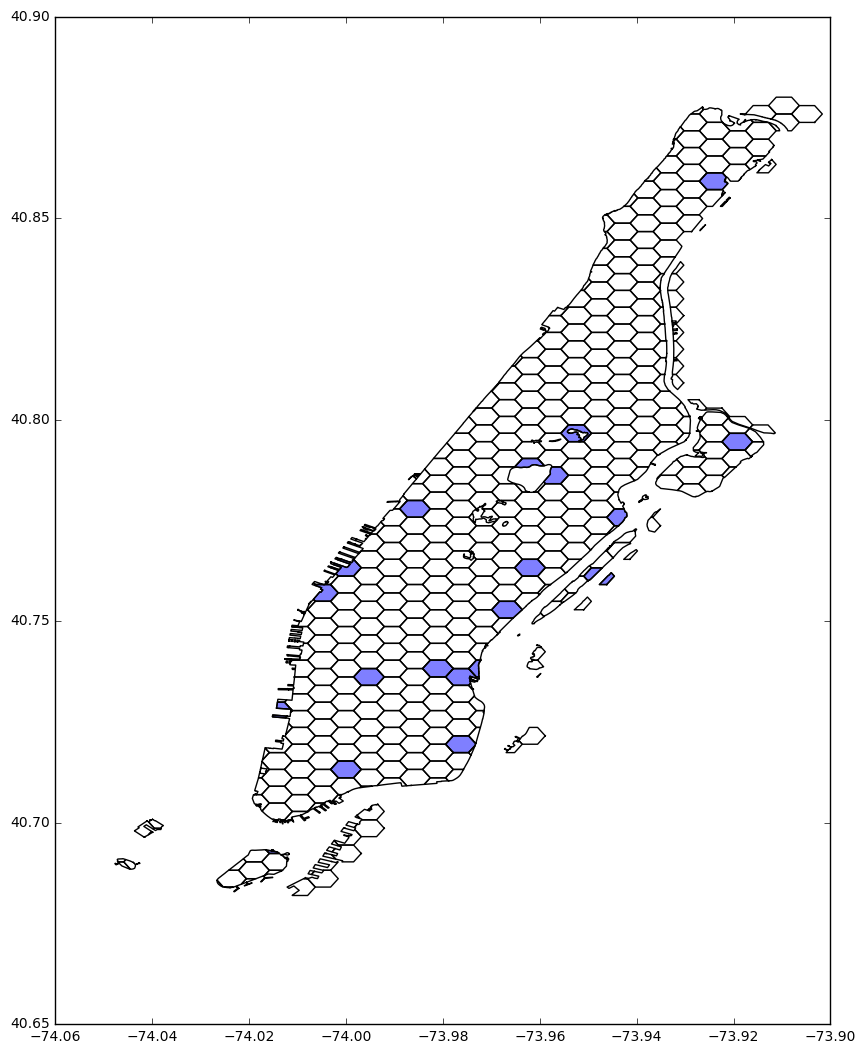

In [24]:
fig0, ax0 = plt.subplots(num=0, figsize=(10,13))
df_man.plot(ax=ax0, color='white')
df_man[df_man.GRID_ID.isin(ids)].plot(ax=ax0, color='blue')
#df_man[df_man.rs_count>0].plot(ax=ax0, color='red')

# Final

In [396]:
def togeo(string):
    m = re.findall(r"(\d+.\d+) (\d+.\d+)", string)
    coords = list(map(lambda x: (float(x[0]), float(x[1])), m))
    poly = shapely.geometry.Polygon(coords)
    return poly

In [399]:
df = pd.read_csv('Final_dataset.csv', index_col=0)
df = df.iloc[:, :13]
df.drop(746088, axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df = gpd.GeoDataFrame(df)
df.geometry = df.geometry.apply(togeo)
df.set_geometry('geometry')
df.head()

,GRID_ID,geometry,idle_count,idle_time_count,pickup_count,dropoff_count,violations,parks,rest_indian,rest_cheap,hotel,Bangladesh,rs_count
0,BZ-45,"POLYGON ((73.88922678226744 40.72991440009237,...",0,0,0,0,0,0,0,7,0,0,0
1,CC-66,"POLYGON ((73.8751493522219 40.64022017573762, ...",0.61875,209.3586458,0.396875,1.43125,1,0,0,0,0,0,0
2,CF-32,"POLYGON ((73.85951521552445 40.78556019282625,...",0,0,0,0,0,0,0,0,0,0,0
3,BG-76,"POLYGON ((73.97948851930843 40.59857430474219,...",3.293150685,1175.579635,0.150684932,4.169863014,0,0,0,17,0,0,0
4,CP-44,"POLYGON ((73.8132394398212 40.7339873629611, 7...",1.890410959,428.0338356,1.320547945,16.69041096,1,0,0,4,0,0,0


In [314]:
def distance(p):
    p1, p2 = p
    return np.sqrt((p1.x - p2.x)**2 + (p1.y - p2.y)**2)

def check_d(dis):
    if dis == 0:
        return 0
    elif dis <= 1521:
        return 1
    else:
        return 0

In [374]:
t = df.geometry.centroid
ma = map(distance,product(t, t))
ma = np.array(list(map(check_d, ma))).reshape(len(df),len(df))

In [376]:
ma.shape

(4004, 4004)

In [401]:
mm = np.delete(ma, 2217, 0)
mm = np.delete(mm, 2217, 1)

In [405]:
size = 4003
R = 50
w0 = 0.8
w1 = 0.2
alpha = 10.

In [388]:
df.columns.values[2:]

array(['idle_count', 'idle_time_count', 'pickup_count', 'dropoff_count',
       'violations', 'parks', 'rest_indian', 'rest_cheap', 'hotel',
       'Bangladesh', 'rs_count'], dtype=object)

In [393]:
for i,v in enumerate(df.idle_count):
    try:
        float(v)
    except ValueError:
        print(i,v)

2217  -73.89445203279931 40.78418860645169


In [398]:
df.loc[746088]

GRID_ID             -73.89445316149207 40.78418433640422
geometry            -73.89445315878415 40.78418604465411
idle_count          -73.89445203279931 40.78418860645169
idle_time_count     -73.89445090444644 40.78419116734659
pickup_count        -73.89445090038377 40.78419373017169
dropoff_count       -73.89444977321531 40.78419629106765
violations          -73.89444864486072 40.78419885286301
parks               -73.89444639475359 40.78420055905453
rest_indian         -73.89444626753254 40.78420084709867
rest_cheap          -73.89444526639889 40.78420312084986
hotel                 -73.8944441380439 40.7842056826452
Bangladesh          -73.89444301222999 40.78420738896588
rs_count            -73.89444076076748 40.78420994973246
Name: 746088, dtype: object

In [403]:
for c in df.columns.values[2:]:
    df[c] = df[c].astype(float)

In [ ]:
trs_model = pulp.LpProblem("trs Problem", pulp.LpMaximize)

### Independant Variables

x = pulp.LpVariable.dict('x_%s', range(size))
y = pulp.LpVariable.dict('y_%s', range(size), lowBound=0, upBound=1, cat="Binary")

### Object Function

c = df.apply(lambda row: (row['violations']+1)/(row["idle_count"]+1), axis=1)
trs_model += sum([c[i] * x[i] for i in range(size)])

### Constraints

trs_model += sum([y[i] for i in range(size)]) <= R

for i in range(size):
    trs_model += x[i] <= df.loc[i, "idle_count"]/alpha
    trs_model += x[i] <= w0*y[i] + w1*sum([y[j] for j in np.where(mm[i, :] == 1)[0]])

In [ ]:
trs_model.solve()

In [ ]:
ids = []
for v in trs_model.variables():
    if v.name.startswith("y") & (v.varValue == 1):
        ids.append(df_man.loc[int(v.name[2:]),'GRID_ID'])
ids

In [ ]:
fig1, ax1 = plt.subplots(num=1, figsize=(10,13))
df.plot(ax=ax0, color='white')
df[df.GRID_ID.isin(ids)].plot(ax=ax0, color='blue')